In [3]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

from wrangle import process_service_data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("fivethirtyeight")

    How many different cases are there, by department?
    
    Does the percentage of cases that are late vary by department?
    
    On average, how late are the late cases by department?
    
    What is the service type that is the most late? Just for Parks & Rec?
    
    For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.
    
    On average, how many cases are opened a day for the Customer Service department?
    
    Does the number of service requests for the solid waste department vary by day of the week?


In [4]:
df = process_service_data()
df.show(1, vertical=True, truncate=False)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 SLA_due_date         | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 request_address      | 2315  el paso st, san antonio, 78207 
 council_district     | 005                                  
 source_id            | svcCRMLS                             
 source_username      | svcCRMLS                             
 dept_division        | Field Operations                     
 dept_na

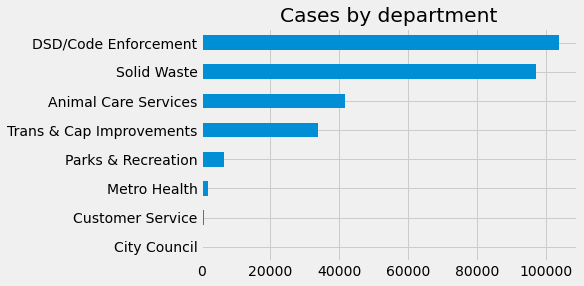

In [17]:
(df.groupBy("department").count()
    .toPandas()               
    .set_index("department")["count"]
    .sort_values()
    .plot.barh()
)
plt.title("Cases by department")
plt.ylabel("");

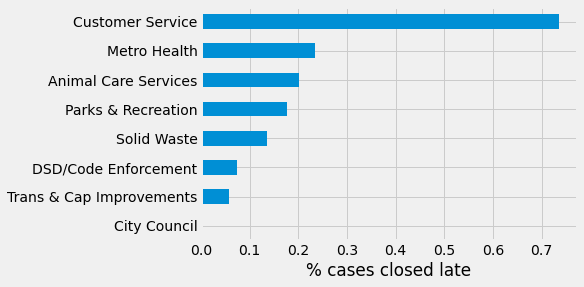

In [15]:
(df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("p_cases_late"))
    .toPandas()
    .set_index("department")
    .p_cases_late.sort_values()
    .plot.barh()
)
plt.gca().set(ylabel="", xlabel="% cases closed late");

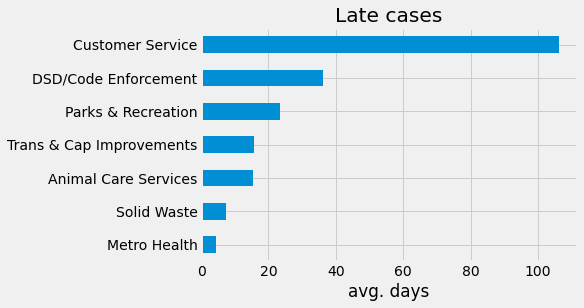

In [22]:
(df.filter("case_late")
    .groupby("department")
    .agg(avg("num_days_late").alias("avg_days_late"))
    .toPandas()
    .set_index("department")
    .avg_days_late.sort_values()
    .plot.barh()
)
plt.gca().set(ylabel="", xlabel="avg. days", title="Late cases");

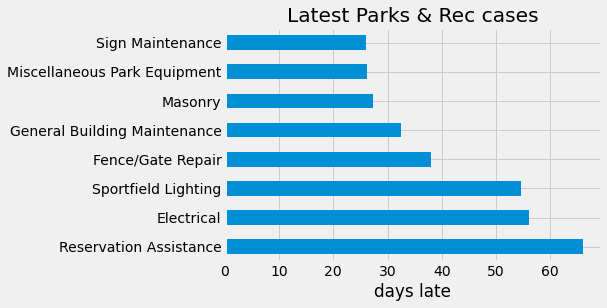

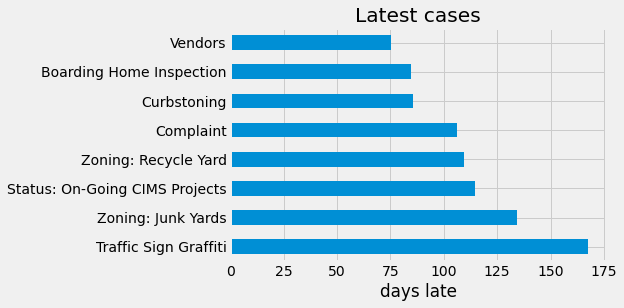

In [25]:
(df.filter(df.case_late)
    .filter(df.department == "Parks & Recreation")
    .groupby("service_request_type")
    .agg(mean("num_days_late").alias("avg_days_late"))
    .sort(desc("avg_days_late"))
    .limit(8)  #limit in spark, not pandas
    .toPandas()
    .set_index("service_request_type")
    .avg_days_late
    .plot.barh()
)
plt.gca().set(title="Latest Parks & Rec cases",
              xlabel="days late", ylabel="");
plt.show()
(df.filter(df.case_late)
    .groupby("service_request_type")
    .agg(mean("num_days_late").alias("avg_days_late"))
    .sort(desc("avg_days_late"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")
    .avg_days_late
    .plot.barh()
)
plt.gca().set(title="Latest cases", xlabel="days late", ylabel="");

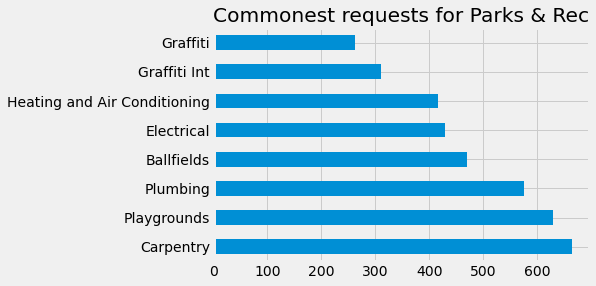

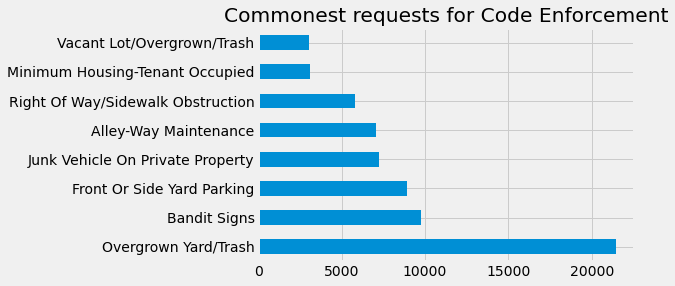

In [40]:
(df.filter(expr('department == "Parks & Recreation"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh()
)
plt.gca().set(ylabel="", xlabel="", title="Commonest requests for Parks & Rec")
plt.show()
(df.filter(expr('department == "DSD/Code Enforcement"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh()
)
plt.gca().set(ylabel="", xlabel="", title="Commonest requests for Code Enforcement");

In [5]:
cases = df.withColumn("case_opened_date", expr("date(case_opened_date)"))\
            .filter(df.department == "Customer Service").groupby("case_opened_date")\
            .count().toPandas().pipe(lambda x: x['count'])  #pipe takes our data frame and "pipes" the dataframe into a function
print(f"{np.round(cases.mean(),1)} Customer Service cases opened per day with a stdev. of {np.round(cases.std(),1)}")

5.6 Customer Service cases opened per day with a stdev. of 3.4


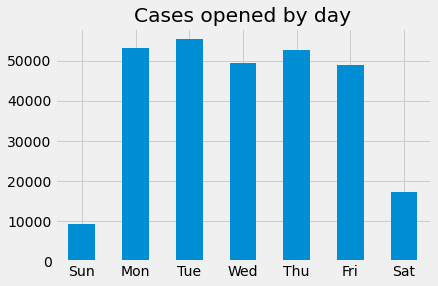

In [29]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(df.withColumn("weekday", date_format("case_opened_date", "E")) #Spark API
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday,
                                              categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar()
)
plt.xticks(rotation=0)
plt.gca().set(xlabel="", ylabel="", title="Cases opened by day");

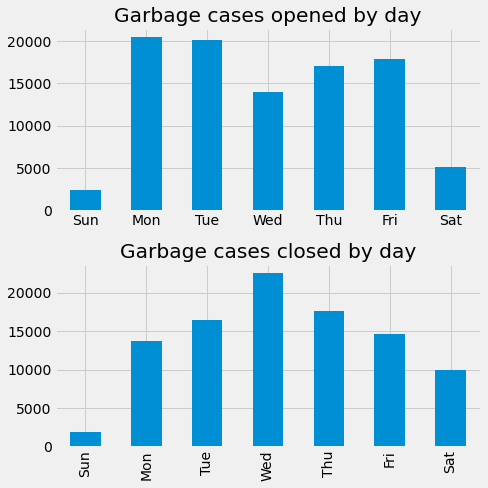

In [35]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,7))

(df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday,
                                              categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(title='Garbage cases opened by day', xlabel="")
ax1.tick_params(axis='x', labelrotation=0)

(df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(title='Garbage cases closed by day', xlabel="")
fig.tight_layout()